# Look at the optimzation progress for DYCORS
David Eriksson <dme65@cornell.edu>

In [33]:
from pySOT.adaptive_sampling import CandidateDYCORS
from pySOT.experimental_design import SymmetricLatinHypercube
from pySOT.strategy import GlobalStrategy, SRBFStrategy
from pySOT.surrogate import RBFInterpolant, CubicKernel, LinearTail, SurrogateUnitBox
from pySOT.optimization_problems import Ackley
from pySOT.utils import progress_plot
from poap.controller import ThreadController, SerialController, BasicWorkerThread
import numpy as np

import matplotlib.pylab as plt
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 

## Use Ackley in 20 dimensions

In [34]:
nthreads = 4
max_evals = 250

ackley = Ackley(dim=20)
print(ackley.info)

rbf = RBFInterpolant(dim=ackley.dim, kernel=CubicKernel(), tail=LinearTail(ackley.dim))
dycors = CandidateDYCORS(opt_prob=ackley, max_evals=max_evals, numcand=100*ackley.dim)
slhd = SymmetricLatinHypercube(dim=ackley.dim, npts=2*(ackley.dim + 1))

20-dimensional Ackley function 
Global optimum: f(0,0,...,0) = 0


## Run asynchronously

In [35]:
controller_async = ThreadController()
controller_async.strategy = \
        SRBFStrategy(max_evals=max_evals, opt_prob=ackley, asynchronous=True,
                     exp_design=slhd, surrogate=rbf, adapt_sampling=dycors,
                     batch_size=nthreads)

for _ in range(nthreads):
    worker = BasicWorkerThread(controller_async, ackley.eval)
    controller_async.launch_worker(worker)
    
result_async = controller_async.run()

## Run synchronously

In [36]:
controller_sync = ThreadController()
controller_sync.strategy = \
        SRBFStrategy(max_evals=max_evals, opt_prob=ackley, asynchronous=False,
                     exp_design=slhd, surrogate=rbf, adapt_sampling=dycors,
                     batch_size=nthreads)

for _ in range(nthreads):
    worker = BasicWorkerThread(controller_sync, ackley.eval)
    controller_sync.launch_worker(worker)

result_sync = controller_sync.run()

## Run in serial

In [37]:
controller_serial = SerialController(objective=ackley.eval)
controller_serial.strategy = \
        SRBFStrategy(max_evals=max_evals, opt_prob=ackley, asynchronous=False,
                     exp_design=slhd, surrogate=rbf, adapt_sampling=dycors,
                     batch_size=1)

result_serial = controller_serial.run()

## Compare the results

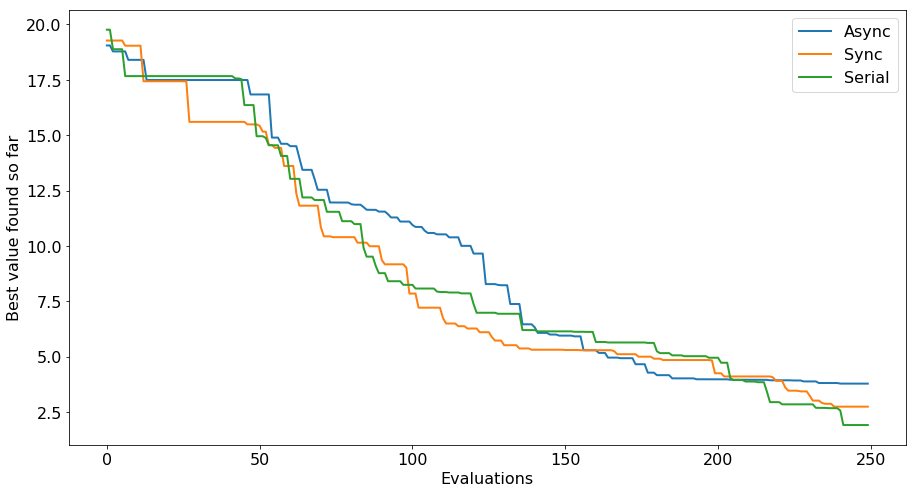

In [39]:
plt.figure(figsize=(15, 8))
for controller in [controller_async, controller_sync, controller_serial]:
    fvals = np.array([o.value for o in controller.fevals if o.value is not None])
    plt.plot(np.arange(0, fvals.shape[0]), np.minimum.accumulate(fvals), lw=2)
plt.ylabel("Best value found so far", fontsize=16)
plt.xlabel("Evaluations", fontsize=16)
plt.legend(("Async", "Sync", "Serial"), fontsize=16)
plt.show()